# 3DGS-DIFF Notebook 

Current goals: <br />
- Experiment with rendering of objects <br />
- From different views <br />
- Take test views from dataset (defined poses) - use for rendering: currently not possible, due to errors with pre training with eval flag that come up on training of contrastive features <br />
- Select Pose around scene - similar to gui <br />


# Imports and arguments merging

In [1]:
import time
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import pytorch3d.ops
from plyfile import PlyData, PlyElement
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from argparse import ArgumentParser, Namespace
import cv2

from arguments import ModelParams, PipelineParams
from scene import Scene, GaussianModel, FeatureGaussianModel
from gaussian_renderer import render, render_contrastive_feature

from utils.sh_utils import SH2RGB

def get_combined_args(parser : ArgumentParser, model_path, target_cfg_file = None): # 
    cmdlne_string = ['--model_path', model_path]
    cfgfile_string = "Namespace()"
    args_cmdline = parser.parse_args(cmdlne_string)
    
    if target_cfg_file is None:
        if args_cmdline.target == 'seg':
            target_cfg_file = "seg_cfg_args"
        elif args_cmdline.target == 'scene' or args_cmdline.target == 'xyz':
            target_cfg_file = "cfg_args"
        elif args_cmdline.target == 'feature' or args_cmdline.target == 'coarse_seg_everything' or args_cmdline.target == 'contrastive_feature' :
            target_cfg_file = "feature_cfg_args"

    try:
        cfgfilepath = os.path.join(model_path, target_cfg_file)
        print("Looking for config file in", cfgfilepath)
        with open(cfgfilepath) as cfg_file:
            print("Config file found: {}".format(cfgfilepath))
            cfgfile_string = cfg_file.read()
    except TypeError:
        print("Config file found: {}".format(cfgfilepath))
        pass
    args_cfgfile = eval(cfgfile_string)

    merged_dict = vars(args_cfgfile).copy()
    for k,v in vars(args_cmdline).items():
        if v != None:
            merged_dict[k] = v

    return Namespace(**merged_dict)

/home/stud/ribe/miniconda3/envs/gaussian_splatting/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Hyperparameters - Paths Setup

In [2]:
import os
FEATURE_DIM = 32 # fixed

# MODEL_PATH = './output/305b90ae-c' ##(3dgs pre training with only training views)
MODEL_PATH = './output/ca50c0c0-7'   ## train/test split every 8th frame


FEATURE_GAUSSIAN_ITERATION = 10000

SCALE_GATE_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/scale_gate.pt')

FEATURE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/contrastive_feature_point_cloud.ply')
SCENE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/scene_point_cloud.ply')

# Data and Model Preparation - Scene and Models Initialization

In [3]:
scale_gate = torch.nn.Sequential(
    torch.nn.Linear(1, 32, bias=True),
    torch.nn.Sigmoid()
)

scale_gate.load_state_dict(torch.load(SCALE_GATE_PATH))
scale_gate = scale_gate.cuda()

parser = ArgumentParser(description="Testing script parameters")
model = ModelParams(parser, sentinel=True)
pipeline = PipelineParams(parser)
parser.add_argument('--target', default='scene', type=str)

args = get_combined_args(parser, MODEL_PATH)

dataset = model.extract(args)

# If use language-driven segmentation, load clip feature and original masks
dataset.need_features = False

# To obtain mask scales
dataset.need_masks = True

scene_gaussians = GaussianModel(dataset.sh_degree)

feature_gaussians = FeatureGaussianModel(FEATURE_DIM)
scene = Scene(dataset, scene_gaussians, feature_gaussians, load_iteration=-1, feature_load_iteration=FEATURE_GAUSSIAN_ITERATION, shuffle=False, mode='eval', target='contrastive_feature')


Looking for config file in ./output/ca50c0c0-7/cfg_args
Config file found: ./output/ca50c0c0-7/cfg_args
Loading trained model at iteration 30000, 10000
Allow Camera Principle Point Shift: False
Reading camera 303/303
Loading Training Cameras
Loading Test Cameras


# Scale Normalization with QuantileTransformer

In [4]:
from sklearn.preprocessing import QuantileTransformer
# Borrowed from GARField, but modified
def get_quantile_func(scales: torch.Tensor, distribution="normal"):
    """
    Use 3D scale statistics to normalize scales -- use quantile transformer.
    """
    scales = scales.flatten()

    scales = scales.detach().cpu().numpy()
    print(scales.max(), '?')

    # Calculate quantile transformer
    quantile_transformer = QuantileTransformer(output_distribution=distribution)
    quantile_transformer = quantile_transformer.fit(scales.reshape(-1, 1))

    
    def quantile_transformer_func(scales):
        scales_shape = scales.shape

        scales = scales.reshape(-1,1)
        
        return torch.Tensor(
            quantile_transformer.transform(scales.detach().cpu().numpy())
        ).to(scales.device).reshape(scales_shape)

    return quantile_transformer_func, quantile_transformer
    
all_scales = []
for cam in scene.getTrainCameras():
    all_scales.append(cam.mask_scales)
all_scales = torch.cat(all_scales)

upper_bound_scale = all_scales.max().item()
# upper_bound_scale = np.percentile(all_scales.detach().cpu().numpy(), 75)

# all_scales = []
# for cam in scene.getTrainCameras():
#     cam.mask_scales = torch.clamp(cam.mask_scales, 0, upper_bound_scale).detach()
#     all_scales.append(cam.mask_scales)
# all_scales = torch.cat(all_scales)

# quantile transformer
q_trans, q_trans_ = get_quantile_func(all_scales, 'uniform')

72.39713 ?


In [5]:
all_scales.max()

tensor(72.3971, grad_fn=<MaxBackward1>)

In [ ]:
# For saving the normal q_trans, if the q_trans is uniform, we don't have to save it

# from joblib import dump, load
# dump(q_trans_, 'quantile_trans_test.jl')
# a = load('quantile_trans_test.jl')

In [6]:
upper_bound_scale

72.39713287353516

In [7]:
q_trans(torch.Tensor([70]))

tensor([1.])

# Prepare for segmentation

In [8]:
from copy import deepcopy
cameras = scene.getTrainCameras()
print("There are",len(cameras),"views in the dataset.")
print(upper_bound_scale)

There are 265 views in the dataset.
72.39713287353516


# Feature Conditioning and Similarity Query

Rerun feature rendering when changing query

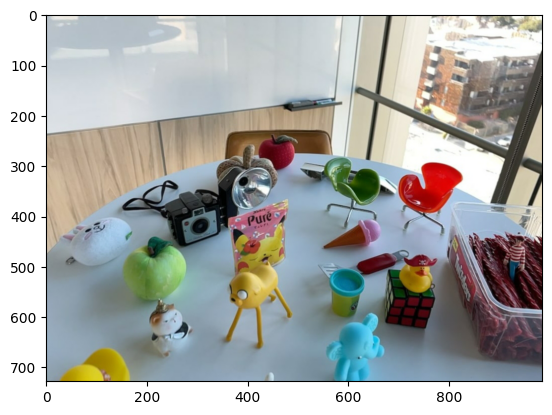

In [9]:
ref_img_camera_id = 13
mask_img_camera_id = 0

view = deepcopy(cameras[ref_img_camera_id])

view.feature_height, view.feature_width = view.image_height, view.image_width
img = view.original_image * 255
img = img.permute([1,2,0]).detach().cpu().numpy().astype(np.uint8)

bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_feature = render_contrastive_feature(view, feature_gaussians, pipeline.extract(args), background, norm_point_features=True, smooth_type = None)['render']
feature_h, feature_w = rendered_feature.shape[-2:]


plt.imshow(img)

# Point Prompt

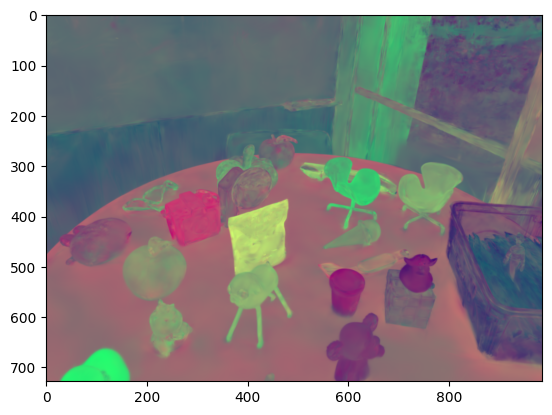

In [10]:
with torch.no_grad():
    # If the q_trans is normal
    # scale = 2.
    # scale = torch.full((1,), scale).cuda()
    # scale = q_trans(scale)

    # If the q_trans is uniform, the scale can be any value between 0 and 1
    # scale = torch.tensor([0]).cuda()
    # scale = torch.tensor([0.5]).cuda()
    scale = torch.tensor([1.]).cuda()

    gates = scale_gate(scale)

    feature_with_scale = rendered_feature
    feature_with_scale = feature_with_scale * gates.unsqueeze(-1).unsqueeze(-1)
    scale_conditioned_feature = feature_with_scale.permute([1,2,0])

    # plt.imshow(scale_conditioned_feature[:,:,:3].detach().cpu().numpy()) # ? img = (img - img.min()) / (img.max() - img.min())  # Normalize for display
    img = scale_conditioned_feature[:, :, :3].detach().cpu().numpy() ### new fix 07.2025
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for display
    plt.imshow(img)


# COORDINATE SELECTION

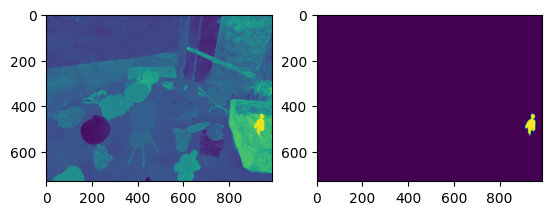

In [11]:
# query_index = (400, 250) # object selection
# query_index = (400, 600) # cup
# query_index = (380, 600) # elephant
# query_index = (350, 700)
query_index = (500, 940)

query_index = (
    int(query_index[0] / view.image_height * view.feature_height),
    int(query_index[1] / view.image_width * view.feature_width),
               )

normed_features = torch.nn.functional.normalize(scale_conditioned_feature, dim = -1, p = 2)
query_feature = normed_features[query_index[0], query_index[1]]

similarity = torch.einsum('C,HWC->HW', query_feature, normed_features)

plt.subplot(1,2,1)
plt.imshow(similarity.detach().cpu().numpy())
plt.subplot(1,2,2)
plt.imshow(similarity.detach().cpu().numpy() > 0.75)

In [12]:
# SHOW PCA in 2D

# # CHW -> PCA dimension reduction DHW (D=3)

# from sklearn.decomposition import PCA

# pca = PCA(n_components=3)


# # t = pca.fit_transform(torch.nn.functional.normalize(rendered_feature, dim = 0).reshape(rendered_feature.shape[0], -1).permute([1,0]).cpu().detach().numpy())
# t = pca.fit_transform(normed_features.reshape(-1, normed_features.shape[-1]).cpu().detach().numpy())

# t = (t - t.min(axis=0)) / (t.max(axis=0)-t.min(axis=0))
# t = t.reshape(normed_features.shape[0], normed_features.shape[1], 3)
# plt.imshow(t)

# Cluster in 2D

Downsample features for clustering and normalize features across feature dim:

In [13]:
downsampled_features = torch.nn.functional.interpolate(scale_conditioned_feature.permute([2,0,1]).unsqueeze(0), (128, 128), mode = 'bilinear').squeeze()
cluster_normed_features = torch.nn.functional.normalize(downsampled_features, dim = 0, p = 2).permute([1,2,0])

run hdbscan clustering:

In [14]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, cluster_selection_epsilon=0.01)
cluster_labels = clusterer.fit_predict(cluster_normed_features.reshape([-1, cluster_normed_features.shape[-1]]).detach().cpu().numpy())
labels = cluster_labels.reshape([cluster_normed_features.shape[0], cluster_normed_features.shape[1]])
print(np.unique(labels))

cluster_centers = torch.zeros(len(np.unique(labels))-1, cluster_normed_features.shape[-1])
for i in range(1, len(np.unique(labels))):
    cluster_centers[i-1] = torch.nn.functional.normalize(cluster_normed_features[labels == i-1].mean(dim = 0), dim = -1)

label_to_color = np.random.rand(200, 3)

/home/stud/ribe/miniconda3/envs/gaussian_splatting/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/stud/ribe/miniconda3/envs/gaussian_splatting/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]


Got 41 clusters from previous cell and one noise class -1

# Visualize clusters:

In [15]:

label_to_color = np.random.rand(200, 3)
segmentation_res = torch.einsum('nc,hwc->hwn', cluster_centers.cuda(), normed_features)

segmentation_res_idx = segmentation_res.argmax(dim = -1)
colored_labels = label_to_color[segmentation_res_idx.cpu().numpy().astype(np.int8)]

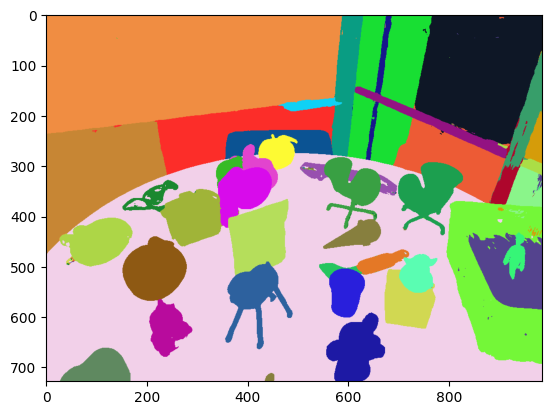

In [16]:
plt.imshow(colored_labels)

# Segmentation in 3D

In [17]:
point_features = feature_gaussians.get_point_features

scale_conditioned_point_features = point_features * gates.unsqueeze(0)


Apply query to 3d points:

In [18]:
normed_scale_conditioned_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)

similarities = torch.einsum('C,NC->N', query_feature.cuda(), normed_scale_conditioned_point_features)

similarities[similarities < 0.5] = 0

Render similarities as grayscale overlay, object bright, background dim:

In [19]:
bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_similarities = render(cameras[5], scene_gaussians, pipeline.extract(args), background, override_color=similarities.unsqueeze(-1).repeat([1,3]))['render']

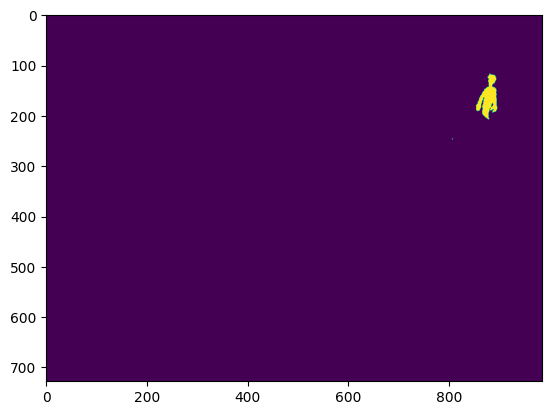

In [20]:
plt.imshow(rendered_similarities.permute([1,2,0])[:,:,0].detach().cpu() > 0.6)

In [21]:
try:
    scene_gaussians.roll_back()
except:
    pass
scene_gaussians.segment(similarities > 0.75)

In [22]:
# save the segmentation mask
name = 'precomputed_mask'
import os
os.makedirs('./segmentation_res', exist_ok=True)
torch.save(similarities > 0.75, f'./segmentation_res/{name}.pt')

# Render segmented object:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.020111432..1.0256339].


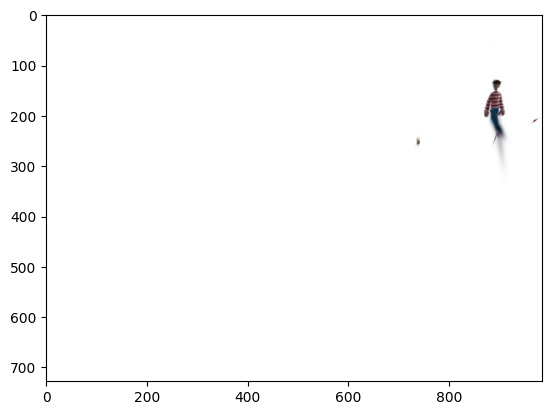

In [23]:
bg_color = [1 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_segmented_image = render(cameras[0], scene_gaussians, pipeline.extract(args), background)['render']
plt.imshow(rendered_segmented_image.permute([1,2,0]).detach().cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0059531876..1.0759218].


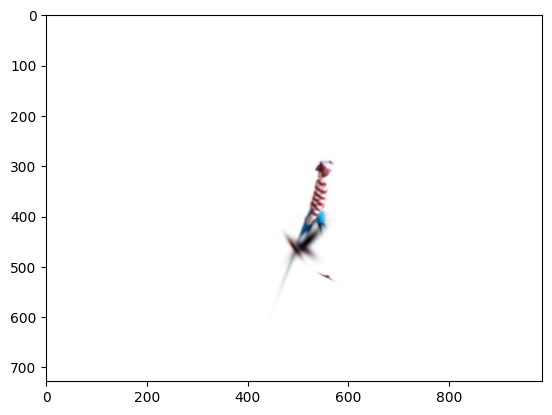

In [24]:
bg_color = [1 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_segmented_image = render(cameras[40], scene_gaussians, pipeline.extract(args), background)['render']
plt.imshow(rendered_segmented_image.permute([1,2,0]).detach().cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.020111432..1.0256339].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0059531876..1.0759218].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0033203831..1.0110724].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0048653134..1.0233185].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0029102976..1.046098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0027121757..1.0575936].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range 

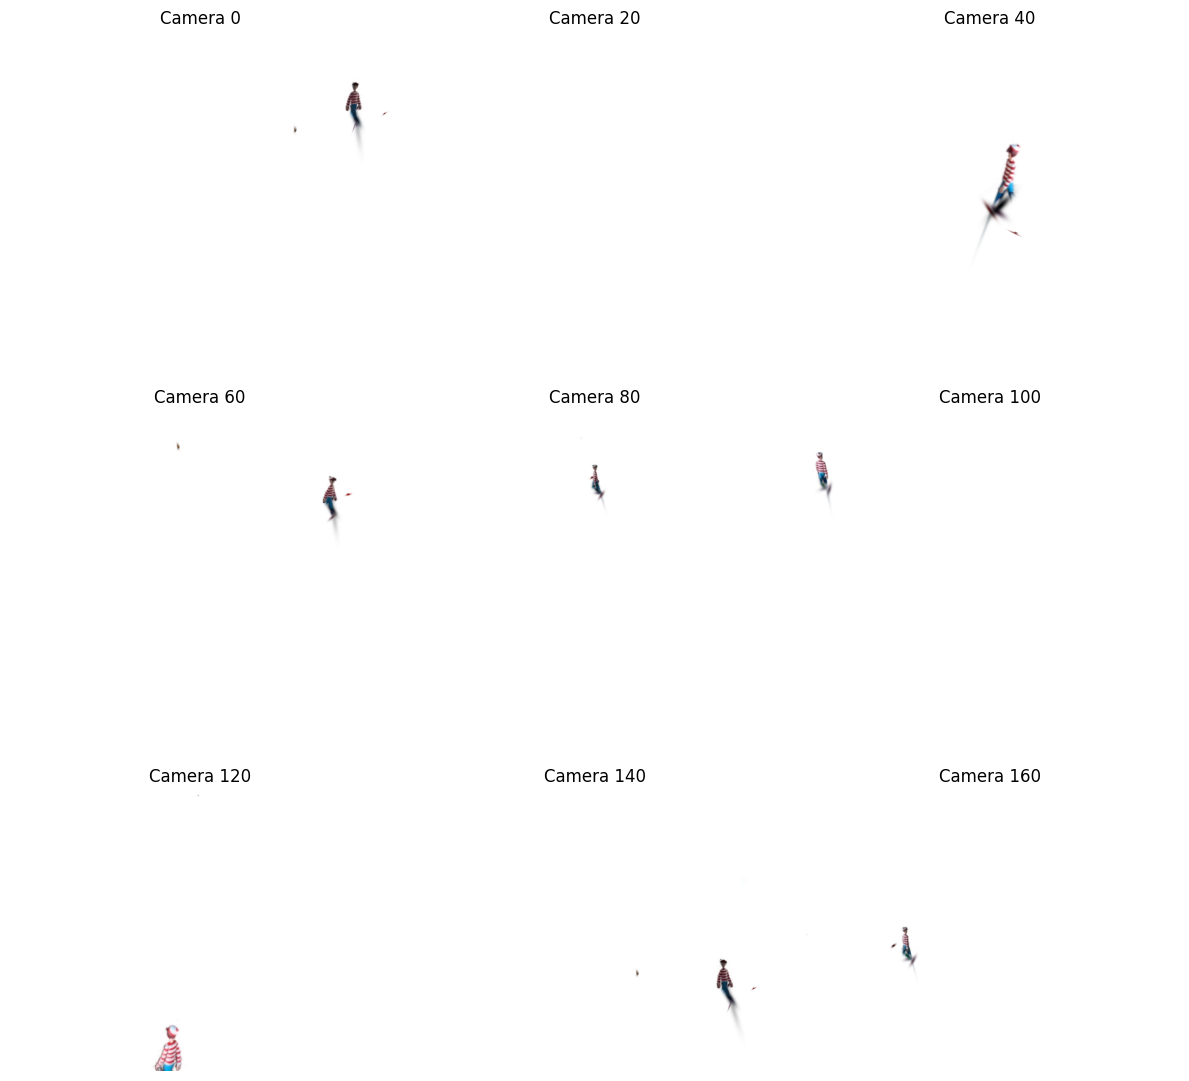

In [25]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for ax, cam_id in zip(axs.flatten(), [0, 20, 40, 60, 80, 100, 120, 140, 160]):
    rendered = render(cameras[cam_id], scene_gaussians, pipeline.extract(args), background)['render']
    image = rendered.permute(1, 2, 0).detach().cpu().numpy()
    ax.imshow(image)
    ax.set_title(f'Camera {cam_id}')
    ax.axis('off')
plt.tight_layout()
plt.show()


# Video / GIF

In [67]:
import imageio
# fig, axs = plt.subplots(3, 3, figsize=(12, 12))
gifFrames = [] ###
for cam_id in ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]):
    rendered = render(cameras[cam_id], scene_gaussians, pipeline.extract(args), background)['render']
    image = (rendered.permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8)
    # ax.imshow(image)
    # ax.set_title(f'Camera {cam_id}')
    # ax.axis('off')
    gifFrames.append(image) ##
# plt.tight_layout()
# plt.show()
# gifFrames = np.array(gifFrames)
# print(gifFrames.shape)
imageio.mimwrite('cup2.gif', gifFrames, loop=65535)



# gifFrames = []
# for i in range(len(images)):
#     gifFrames.append(images[i])
# imageio.mimwrite('test.gif', gifFrames, loop=65535)

# imageio.mimwrite("test.mp4", gifFrames, fps=2, quality=10, macro_block_size=1)


# Test Views?

In [26]:
test_cameras = scene.getTestCameras()
for i, cam in enumerate(test_cameras):
    print(i, cam.image_name)

0 frame_00001
1 frame_00009
2 frame_00017
3 frame_00025
4 frame_00033
5 frame_00041
6 frame_00049
7 frame_00057
8 frame_00065
9 frame_00073
10 frame_00081
11 frame_00089
12 frame_00097
13 frame_00105
14 frame_00113
15 frame_00121
16 frame_00129
17 frame_00137
18 frame_00145
19 frame_00153
20 frame_00161
21 frame_00169
22 frame_00177
23 frame_00185
24 frame_00193
25 frame_00201
26 frame_00209
27 frame_00217
28 frame_00225
29 frame_00233
30 frame_00241
31 frame_00249
32 frame_00257
33 frame_00265
34 frame_00273
35 frame_00281
36 frame_00289
37 frame_00299


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.021966886..1.0135494].


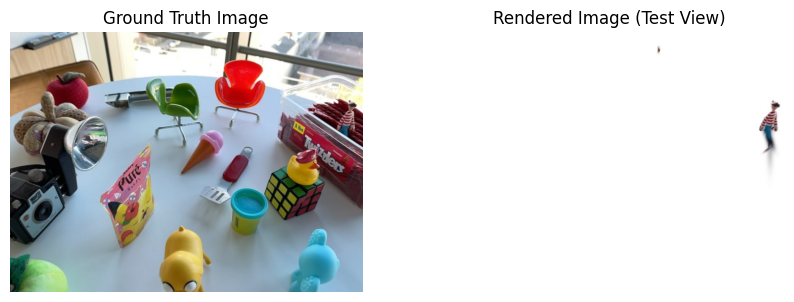

In [28]:
cam = test_cameras[8]
rendered = render(cam, scene_gaussians, pipeline.extract(args), background)['render']
rendered_np = rendered.permute(1, 2, 0).detach().cpu().numpy()
gt_np = cam.original_image.permute(1, 2, 0).detach().cpu().numpy()
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(gt_np)
plt.title("Ground Truth Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rendered_np)
plt.title("Rendered Image (Test View)")
plt.axis('off')

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.014922344..1.0364447].


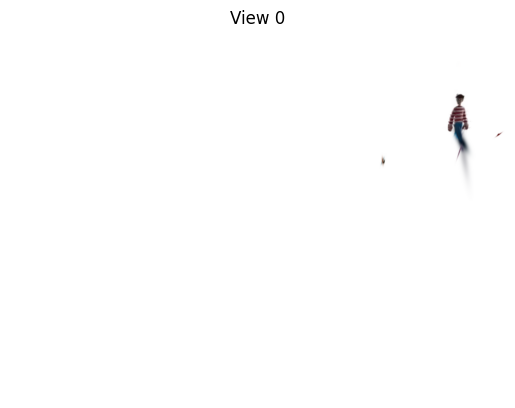

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0057253344..1.0412142].


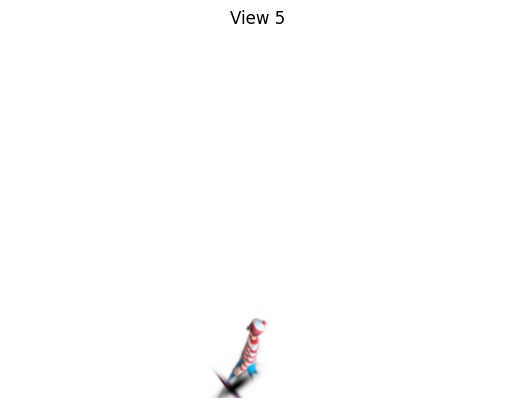

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.002536158..1.0065861].


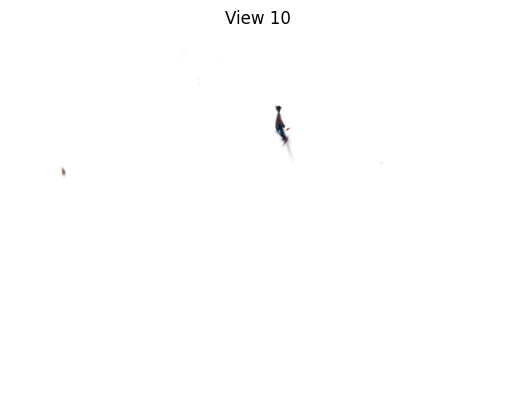

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0010923401..1.0290471].


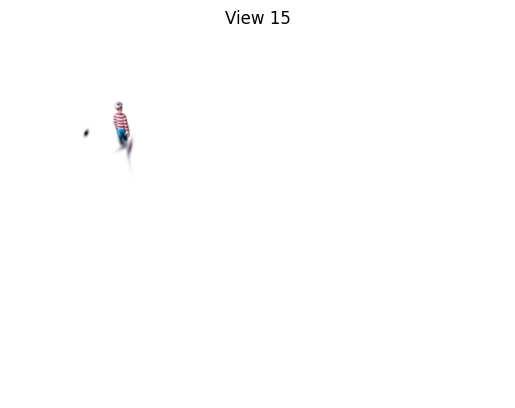

In [29]:
for idx in [0, 5, 10, 15]:
    rendered = render(test_cameras[idx], scene_gaussians, pipeline.extract(args), background)['render']
    plt.imshow(rendered.permute(1,2,0).detach().cpu())
    plt.title(f'View {idx}')
    plt.axis('off')
    plt.show()

In [30]:
import imageio

frames = []
for cam in test_cameras:
    rendered = render(cam, scene_gaussians, pipeline, background)['render']
    image = (rendered.permute(1, 2, 0).detach().cpu().numpy() * 255).astype('uint8')
    frames.append(image)

# Save the gif
imageio.mimsave('wally_test_views.gif', frames, fps=5)


---------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.000110467365..1.0167843].


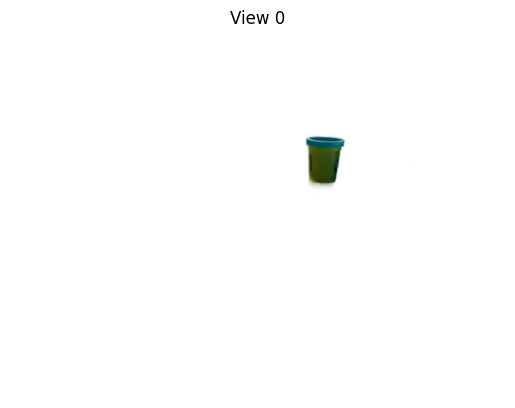

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00012930219..1.0452836].


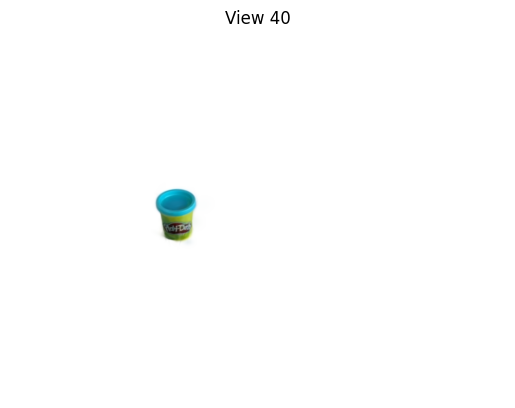

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.000106336534..1.0073854].


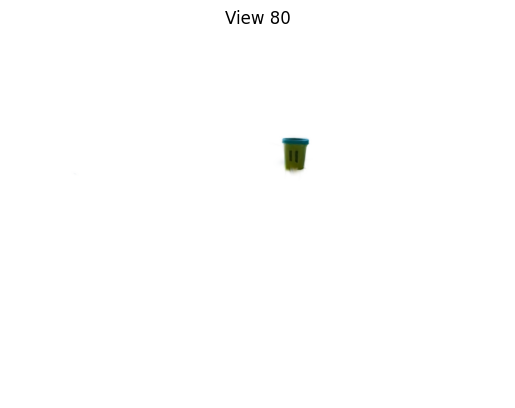

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00015345453..1.0201472].


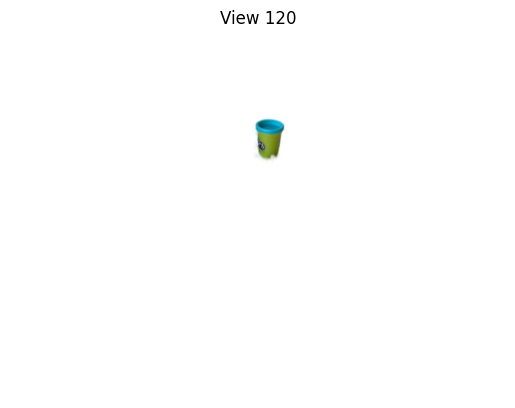

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00010084813..1.0071776].


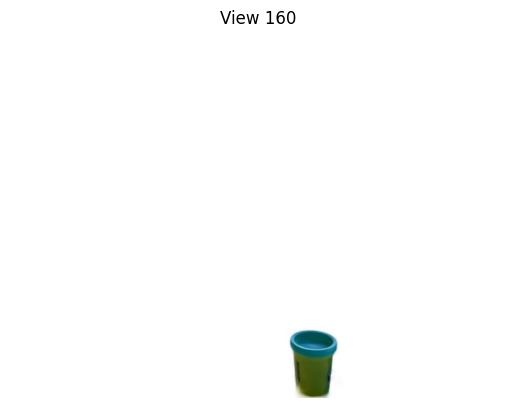

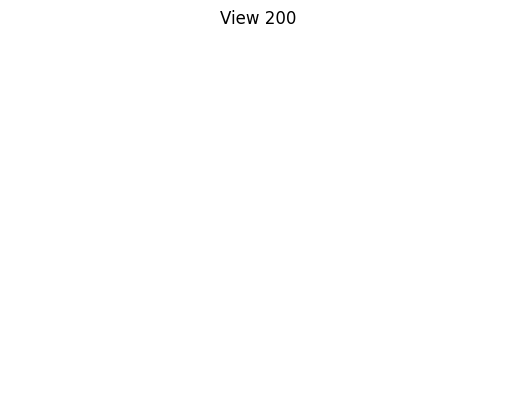

In [99]:
cameras = scene.getTrainCameras()
for idx in [0, 40, 80, 120, 160, 200]:
    rendered = render(cameras[idx], scene_gaussians, pipeline.extract(args), background)['render']
    plt.imshow(rendered.permute(1,2,0).detach().cpu())
    plt.title(f'View {idx}')
    plt.axis('off')
    plt.show()


# evenly spaced views (like rotating around the object):

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.000110467365..1.0167843].


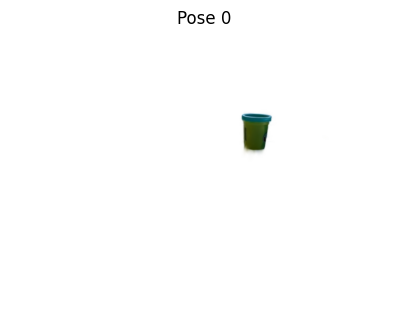

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.000103196035..1.0310751].


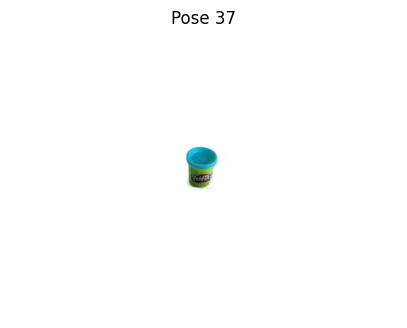

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.000101552985..1.0053762].


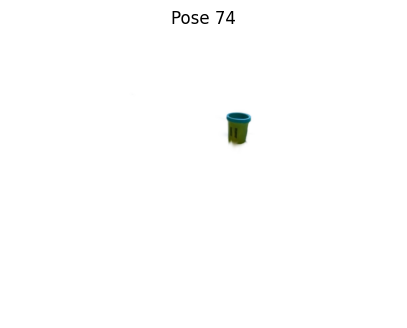

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00012519401..1.0138638].


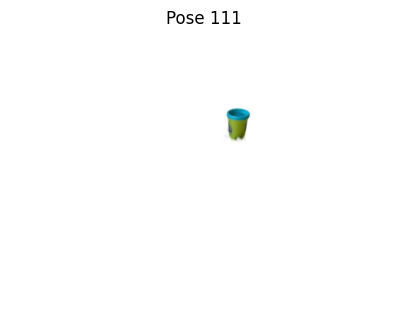

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00015882983..1.0176946].


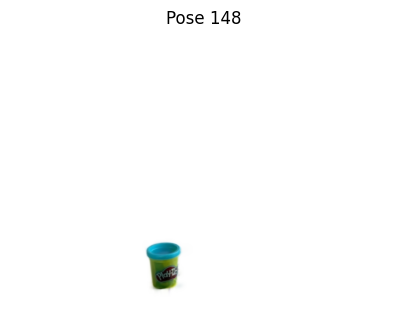

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.000115658695..1.0123045].


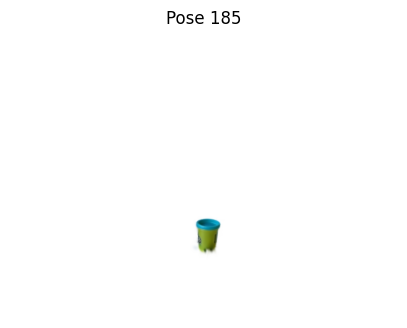

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00013978028..1.0070509].


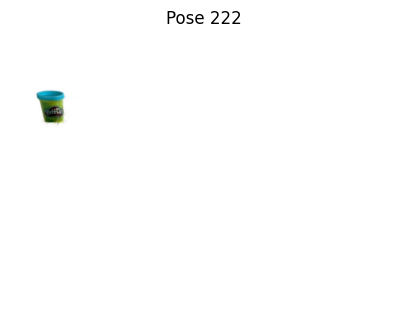

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.000118674856..1.0230852].


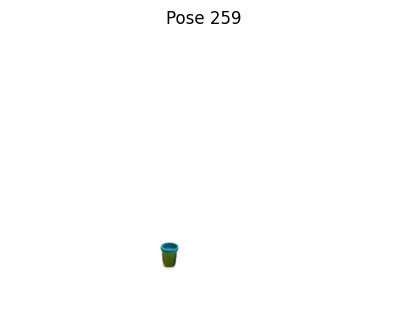

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00010387332..1.0066115].


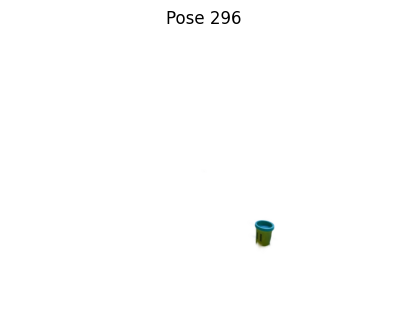

In [ ]:
from copy import deepcopy

bg_color = [1 for _ in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

train_cameras = scene.getTrainCameras()

step = len(train_cameras) // 8  # 8 views around the object
for i in range(0, len(train_cameras), step):
    cam = deepcopy(train_cameras[i])
    rendered = render(cam, scene_gaussians, pipeline.extract(args), background)['render']
    plt.figure(figsize=(5,5))
    plt.imshow(rendered.permute(1, 2, 0).detach().cpu())
    plt.title(f"Pose {i}")
    plt.axis('off')
    plt.show()


In [109]:
print("Train cameras:", len(scene.getTrainCameras()))
print("Test cameras:", len(scene.getTestCameras()))


Train cameras: 303
Test cameras: 0


GUI result?:

In [3]:
import torch
torch.load('segmentation_res/precomputed_mask.pt')

/home/stud/ribe/miniconda3/envs/gaussian_splatting/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([True, True, True,  ..., True, True, True], device='cuda:0')

Simulating orbit?

In [101]:
import math
from scene.cameras import Camera
import torch.nn.functional as F


In [106]:
# Look at matrix
def create_look_at(cam_pos, target, up=(0, 1, 0)):
    cam_pos = torch.tensor(cam_pos, dtype=torch.float32)
    target = torch.tensor(target, dtype=torch.float32)
    up = torch.tensor([0, 1, 0], dtype=torch.float32, device=cam_pos.device)

    z_axis = F.normalize(cam_pos - target, dim=0)  # camera direction
    x_axis = F.normalize(torch.cross(up, z_axis), dim=0)  # right
    y_axis = torch.cross(z_axis, x_axis)  # new up

    R = torch.stack([x_axis, y_axis, z_axis], dim=1)
    T = -R @ cam_pos[:, None]

    view_matrix = torch.eye(4)
    view_matrix[:3, :3] = R
    view_matrix[:3, 3] = T.squeeze()
    return view_matrix


In [108]:
#generate and render views
bg_color = [1 for _ in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

# Use your scene center — approximate using camera centers
centers = torch.stack([cam.camera_center for cam in scene.getTrainCameras()])
scene_center = centers.mean(dim=0)

radius = 2.0  # distance from center
num_views = 8  # how many orbit poses

for i in range(num_views):
    angle = 2 * math.pi * i / num_views  # full circle
    x = radius * math.cos(angle)
    z = radius * math.sin(angle)
    y = 0.5  # elevation

    cam_pos = scene_center + torch.tensor([x, y, z], device=scene_center.device)
    view_matrix = create_look_at(cam_pos, scene_center)

    # Create synthetic camera
    ref_cam = scene.getTrainCameras()[0]
    custom_cam = Camera(
        colmap_id=-1,
        R=view_matrix[:3, :3],
        T=view_matrix[:3, 3],
        FoVx=ref_cam.FoVx,
        FoVy=ref_cam.FoVy,
        image=torch.zeros_like(ref_cam.original_image),
        gt_alpha_mask=torch.ones_like(ref_cam.original_image[0]),  # dummy alpha mask
        image_name=f"synthetic_{i}",
        uid=-1
    )
    custom_cam.image_height = ref_cam.image_height
    custom_cam.image_width = ref_cam.image_width

    # Render
    rendered = render(custom_cam, scene_gaussians, pipeline.extract(args), background)['render']
    plt.figure(figsize=(5, 5))
    plt.imshow(rendered.permute(1, 2, 0).detach().cpu())
    plt.title(f"Custom Pose {i}")
    plt.axis('off')
    plt.show()


/tmp/ipykernel_2961291/2458459669.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cam_pos = torch.tensor(cam_pos, dtype=torch.float32)
/tmp/ipykernel_2961291/2458459669.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.float32)


TypeError: transpose() received an invalid combination of arguments - got (), but expected one of:
 * (int dim0, int dim1)
 * (name dim0, name dim1)


In [97]:
from copy import deepcopy

# Choose N test camera views
test_cameras = scene.getTestCameras()
selected_views = test_cameras[::100] # change number here
print(selected_views)

# Set white background
bg_color = [1 for _ in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

# Render and display each view
for idx, cam in enumerate(selected_views):
    print(idx)
    view = deepcopy(cam)
    
    rendered = render(view, scene_gaussians, pipeline.extract(args), background)['render']
    image = rendered.permute(1, 2, 0).detach().cpu().numpy()

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f'Rendered View {idx}')
    plt.axis('off')
    plt.show()


[]


In [ ]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, cluster_selection_epsilon=0.01)

cluster_labels = clusterer.fit_predict(normed_sampled_point_features.detach().cpu().numpy())
print(np.unique(cluster_labels))

cluster_centers = torch.zeros(len(np.unique(cluster_labels))-1, normed_sampled_point_features.shape[-1])
for i in range(1, len(np.unique(cluster_labels))):
    cluster_centers[i-1] = torch.nn.functional.normalize(normed_sampled_point_features[cluster_labels == i-1].mean(dim = 0), dim = -1)

/home/stud/ribe/miniconda3/envs/gaussian_splatting/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/stud/ribe/miniconda3/envs/gaussian_splatting/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92]


In [73]:
scene_gaussians.roll_back()

# Cluster in 3D

In [25]:
point_features = feature_gaussians.get_point_features

scale_conditioned_point_features = torch.nn.functional.normalize(point_features, dim = -1, p = 2) * gates.unsqueeze(0)

normed_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)

sampled_point_features = scale_conditioned_point_features[torch.rand(scale_conditioned_point_features.shape[0]) > 0.98]

normed_sampled_point_features = sampled_point_features / torch.norm(sampled_point_features, dim = -1, keepdim = True)

print(len(sampled_point_features))

38323


In [26]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, cluster_selection_epsilon=0.01)

cluster_labels = clusterer.fit_predict(normed_sampled_point_features.detach().cpu().numpy())
print(np.unique(cluster_labels))

cluster_centers = torch.zeros(len(np.unique(cluster_labels))-1, normed_sampled_point_features.shape[-1])
for i in range(1, len(np.unique(cluster_labels))):
    cluster_centers[i-1] = torch.nn.functional.normalize(normed_sampled_point_features[cluster_labels == i-1].mean(dim = 0), dim = -1)

/home/stud/ribe/miniconda3/envs/gaussian_splatting/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/stud/ribe/miniconda3/envs/gaussian_splatting/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92]


In [27]:
seg_score = torch.einsum('nc,bc->bn', cluster_centers.cpu(), normed_point_features.cpu())

In [28]:
label_to_color = np.random.rand(1000, 3)
point_colors = label_to_color[seg_score.argmax(dim = -1).cpu().numpy()]
point_colors[seg_score.max(dim = -1)[0].detach().cpu().numpy() < 0.5] = (0,0,0)

In [29]:
try:
    scene_gaussians.roll_back()
except:
    pass

In [30]:
bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")


rendered_seg_map = render(cameras[0], scene_gaussians, pipeline.extract(args), background, override_color=torch.from_numpy(point_colors).cuda().float())['render']

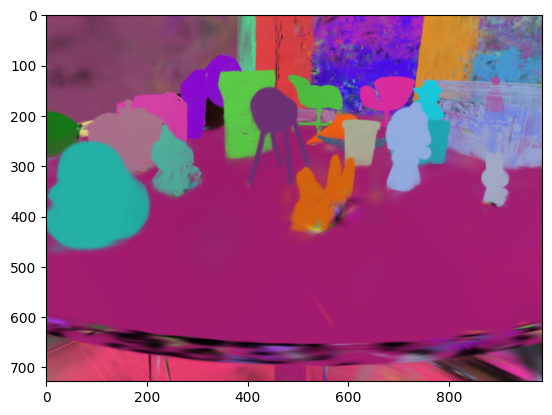

In [31]:
plt.imshow(rendered_seg_map.permute([1,2,0]).detach().cpu().numpy())

Skip Language/clip related for now

# NEW - Render from different camera views

In [35]:
bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")


rendered_seg_map = render(cameras[20], scene_gaussians, pipeline.extract(args), background, override_color=torch.from_numpy(point_colors).cuda().float())['render']

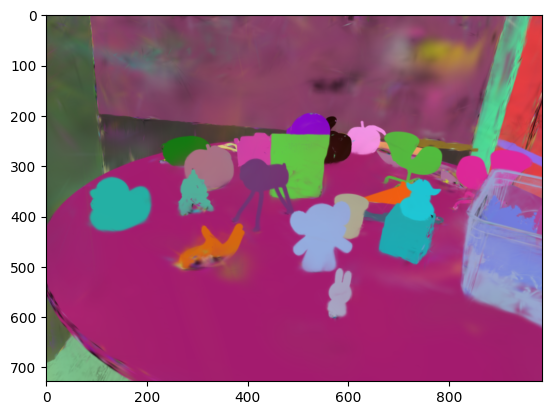

In [36]:
plt.imshow(rendered_seg_map.permute([1,2,0]).detach().cpu().numpy())

To render from test or all cameras:

In [47]:
test_cameras = scene.getTestCameras()
# selected_cameras = test_cameras[::10]  # Take every 20th camera for diversity
selected_cameras = test_cameras


In [48]:
bg_color = [0 for _ in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

for idx, cam in enumerate(selected_cameras):
    view = deepcopy(cam)
    rendered = render_contrastive_feature(view, feature_gaussians, pipeline.extract(args), background, norm_point_features=True)
    rendered_image = rendered['render'].permute(1,2,0).detach().cpu().numpy()

    plt.figure(figsize=(5,5))
    plt.imshow(rendered_image[:,:,:3])
    plt.title(f'View {idx}')
    plt.axis('off')
    plt.show()


In [49]:
from PIL import Image

output_dir = './view_renders'
os.makedirs(output_dir, exist_ok=True)

for idx, cam in enumerate(selected_cameras):
    ...
    img = (rendered_image[:,:,:3] * 255).astype(np.uint8)
    Image.fromarray(img).save(f'{output_dir}/view_{idx:02d}.png')
